In [38]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline
import pyodbc
con = pyodbc.connect('DSN=ISDW')
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics
from sklearn import naive_bayes 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.externals import joblib

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Pull APRC Data and Pull Fail Count Per Quadrant on Chip

In [2]:
daysback = 300
Calcdefs = 'S2561'
corner = 'SRAM256MST00p655CHIPA'
categoryName = 'BIT'

SQLQuery = """
SELECT lot_id_base, APRCTable.wafer_id, APRCTable.ChipX || ', ' || APRCTable.ChipY as ChipXY, family_Code,
     radius_Center_5, quadrant as waf_quadrant, locationType,
     --APRCTable.corner, categoryName as aprc, 
     BitCount, Q0FailCount, Q1FailCount, Q2FailCount, Q3FailCount
     
FROM
(
Select lot_id_base, wafer_Id, ChipX, ChipY, family_Code, radius_Center_5, quadrant, locationType, SUM(BitCount) as BitCount
FROM
(
SELECT left(lot_Id, 5) as lot_id_base, wafer_Id, normalized_TestX as ChipX, normalized_TestY as ChipY, family_Code,
     corner, categoryName, count, radius_Center_5, quadrant, locationType,
     case
         when corner = '{}' and categoryName = '{}' then count
         else 0
     end as BitCount
FROM DMIW.PattRecChipFactR prcfr
JOIN DMIW_SYSTEMS.DerivedDataSetup dds ON prcfr.derivedSetupKey = dds.derivedSetupKey
JOIN DMIW_SYSTEMS.PattRecCategory prc ON prcfr.pattRecCatKey = prc.pattRecCatKey
JOIN DMIW_SYSTEMS.Geography geo ON prcfr.geographyKey = geo.geographyKey
JOIN (select testedWaferKey, lot_Id, wafer_id, family_Code, cur_Lot_Grade as lot_Grade, last_TestTimeStamp as date,
     level, testProgramName, last_Eqp_Id
     from DMIW_SYSTEMS.TestedWafer tw
     where Last_test_date >= (current date - {} days) and Tech_id = '7HPP' and Calcdefs = '{}'
     group by testedWaferKey, lot_Id, wafer_Id, family_Code, cur_Lot_Grade, last_TestTimeStamp, level, 
     testProgramName, last_Eqp_Id) tw ON prcfr.testedWaferKey = tw.testedWaferKey
WHERE categoryName <> '' and exclude_Flag = 'N'
)
GROUP BY lot_id_base, wafer_Id, ChipX, ChipY, family_Code, radius_Center_5, quadrant, locationType
ORDER BY lot_Id_base, wafer_Id, ChipX, ChipY
) APRCTable

JOIN
(
SELECT wafer_Id, ChipX, ChipY,
    SUM(Q0FailCount) as Q0FailCount, SUM(Q1FailCount) as Q1FailCount,
    SUM(Q2FailCount) as Q2FailCount, SUM(Q3FailCount) as Q3FailCount
FROM
(
SELECT wafer_Id, normalized_TestX as ChipX, normalized_TestY as ChipY, tp.parm_Label, parmValue,
     case
         when ucase(tp.parm_Label) = 'S256~H2~Q0_FBC_0P65' then parmValue
         else 0
     end as Q0FailCount,
     case
         when ucase(tp.parm_Label) = 'S256~H2~Q1_FBC_0P65' then parmValue
         else 0
     end as Q1FailCount,
     case
         when ucase(tp.parm_Label) = 'S256~H2~Q2_FBC_0P65' then parmValue
         else 0
     end as Q2FailCount,
     case
         when ucase(tp.parm_Label) = 'S256~H2~Q3_FBC_0P65' then parmValue
         else 0
     end as Q3FailCount
FROM DMIW.ChipParmFactR cpfr
JOIN DMIW_SYSTEMS.TestParm tp ON cpfr.testParmKey = tp.testParmKey
JOIN DMIW_SYSTEMS.Geography geo ON cpfr.geographyKey = geo.geographyKey
JOIN (select testedWaferKey, lot_Id, wafer_Id, family_Code, cur_Lot_Grade as lot_Grade, 
     last_TestTimeStamp as date, level, last_Eqp_Id 
     from DMIW_SYSTEMS.TestedWafer testedWafer 
     where Last_test_date >= (current date - {} days) and Tech_id = '7HPP' and Calcdefs = '{}' 
     group by testedWaferKey, lot_Id, wafer_Id, family_Code, cur_Lot_Grade, last_TestTimeStamp,
     level, last_Eqp_Id) tw ON cpfr.testedWaferKey = tw.testedWaferKey
WHERE cpfr.parmValue is not null and abs(parmValue) < 1e25 and
    (ucase(tp.parm_Label) in ('S256~H2~Q0_FBC_0P65', 'S256~H2~Q1_FBC_0P65', 'S256~H2~Q2_FBC_0P65', 'S256~H2~Q3_FBC_0P65'))
)
GROUP BY wafer_Id, ChipX, ChipY
ORDER BY wafer_Id, ChipX, ChipY
) ElecTable

ON APRCTable.wafer_Id = ElecTable.wafer_Id and APRCTable.ChipX = ElecTable.ChipX and APRCTable.ChipY = ElecTable.ChipY
ORDER BY lot_Id_base, wafer_Id
""".format(corner, categoryName, daysback, Calcdefs, daysback, Calcdefs)

In [3]:
df = pd.read_sql(SQLQuery,con)

In [4]:
df[df.WAFER_ID == 'AZ2WW-11']

,LOT_ID_BASE,WAFER_ID,CHIPXY,FAMILY_CODE,RADIUS_CENTER_5,WAF_QUADRANT,LOCATIONTYPE,BITCOUNT,Q0FAILCOUNT,Q1FAILCOUNT,Q2FAILCOUNT,Q3FAILCOUNT
1708,AZ2WW,AZ2WW-11,"7, 28",HD,E,3,EDGE,280,960.0,302.0,181.0,4.0
1709,AZ2WW,AZ2WW-11,"7, 35",HD,E,2,EDGE,1582,268.0,4803.0,6.0,2283.0
1710,AZ2WW,AZ2WW-11,"16, 21",HD,E,3,INNER,60,9.0,23.0,598.0,18.0
1711,AZ2WW,AZ2WW-11,"16, 28",HD,D,3,INNER,292,61.0,96.0,71.0,64.0
1712,AZ2WW,AZ2WW-11,"16, 35",HD,D,2,INNER,366,100.0,107.0,59.0,118.0
1713,AZ2WW,AZ2WW-11,"16, 42",HD,D,2,INNER,98,18.0,378.0,20.0,30.0
1714,AZ2WW,AZ2WW-11,"25, 14",HD,D,3,INNER,20,3.0,10.0,2.0,5.0
1715,AZ2WW,AZ2WW-11,"25, 21",HD,D,3,INNER,152,50.0,35.0,43.0,24.0
1716,AZ2WW,AZ2WW-11,"25, 28",HD,C,3,INNER,1333,352.0,321.0,324.0,344.0
1717,AZ2WW,AZ2WW-11,"25, 35",HD,C,2,INNER,1965,514.0,512.0,455.0,484.0


In [5]:
pivot = pd.pivot_table(df, values=('BITCOUNT','Q0FAILCOUNT','Q1FAILCOUNT','Q2FAILCOUNT','Q3FAILCOUNT'), index=['WAFER_ID'], columns=['CHIPXY'], aggfunc=np.mean).fillna(0)

In [6]:
pivot

BITCOUNT                                                        \
CHIPXY     16, 21 16, 28 16, 35   16, 42  25, 14 25, 21  25, 28  25, 35   
WAFER_ID                                                                  
AZ2RG-01      0.0    0.0    0.0      0.0     0.0    0.0     0.0     0.0   
AZ2RG-04      1.0    2.0    2.0      1.0     2.0    1.0     3.0     4.0   
AZ2RG-06      0.0    5.0    2.0      0.0     2.0    2.0    10.0    18.0   
AZ2RG-10      0.0    1.0    1.0      0.0     0.0    0.0     8.0     8.0   
AZ2RG-17     69.0    7.0   15.0     46.0     1.0   14.0    32.0    69.0   
AZ2RU-01      3.0   29.0   20.0     19.0     0.0    4.0     3.0     9.0   
AZ2RU-02      7.0   13.0   14.0     19.0     0.0    3.0     1.0     8.0   
AZ2RU-03     24.0    7.0   27.0      2.0     0.0    9.0     7.0    20.0   
AZ2RU-04      5.0  128.0   55.0     14.0    10.0  142.0    17.0    41.0   
AZ2RU-05      3.0   24.0  113.0     36.0    14.0   24.0    11.0    21.0   
AZ2RU-08     35.0   74.0   79.0     29.0     6.0   26.0    27.0   148.0   
AZ2RU-11     33.0  273.0  198.0     13.0    27.0   44.0    42.0    89.0   
AZ2RU-12      2.0   64.0    8.0      4.0     5.0   37.0     8.0    10.0   
AZ2RU-14     23.0   16.0  126.0      3.0    17.0   40.0     4.0    48.0   
AZ2RU-15      8.0   25.0   64.0      2.0     7.0    9.0     3.0    11.0   
AZ2RU-17      8.0   28.0   16.0     35.0     5.0   13.0    10.0    28.0   
AZ2RU-18      6.0    9.0   26.0      4.0     4.0    7.0     3.0    13.0   
AZ2RU-19     15.0    6.0   10.0      1.0     2.0   19.0     2.0     8.0   
AZ2RU-20      5.0   12.0   32.0      3.0     9.0   14.0     5.0    23.0   
AZ2WW-02      2.0    3.0    0.0     22.0  2052.0   12.0   682.0    31.0   
AZ2WW-03      9.0   11.0   11.0      1.0     5.0    5.0     2.0     3.0   
AZ2WW-04      2.0   31.0   35.0      0.0    55.0  180.0    93.0    20.0   
AZ2WW-05      3.0   11.0   54.0      2.0    12.0    8.0     6.0    11.0   
AZ2WW-06      7.0    9.0    2.0      3.0    35.0  126.0    95.0    43.0   
AZ2WW-07     42.0   55.0   74.0     19.0   239.0  315.0   172.0   268.0   
AZ2WW-09      9.0   22.0   71.0      6.0     5.0    8.0     8.0    23.0   
AZ2WW-10     30.0  138.0  221.0     35.0    23.0  106.0   888.0  1570.0   
AZ2WW-11     60.0  292.0  366.0     98.0    20.0  152.0  1333.0  1965.0   
AZ2WW-12     75.0  344.0  264.0     75.0    36.0  470.0  1020.0  1437.0   
AZ2WW-13     24.0   87.0  140.0     29.0     9.0   57.0   314.0   541.0   
...           ...    ...    ...      ...     ...    ...     ...     ...   
AZ3VK-01    248.0  301.0  213.0   1944.0   302.0  330.0   237.0   153.0   
AZ3VK-02    126.0   38.0   43.0    911.0    19.0   57.0    38.0    36.0   
AZ3VK-03    332.0  231.0  134.0   7909.0   335.0  550.0   397.0   192.0   
AZ3VK-04    120.0  132.0   52.0     64.0   164.0  176.0    75.0    41.0   
AZ3VK-05     29.0   38.0   38.0   5205.0    17.0   92.0    42.0    13.0   
AZ3VK-06    113.0  104.0   47.0     41.0   137.0  192.0   100.0    59.0   
AZ3VK-08    598.0  195.0   92.0    115.0   215.0  242.0   121.0    82.0   
AZ3VK-09     31.0   30.0   20.0   4676.0     9.0   35.0    26.0     9.0   
AZ3VK-13     71.0  131.0   75.0   1992.0   123.0  204.0   166.0    48.0   
AZ3VK-16     39.0   16.0   12.0   1919.0     4.0   17.0    16.0     2.0   
AZ3WV-01    215.0   41.0   25.0   1121.0   554.0   44.0    37.0    70.0   
AZ3WV-02    140.0   13.0   26.0   1807.0     7.0   17.0    10.0   111.0   
AZ3WV-03     90.0   42.0   53.0  14740.0    42.0   18.0    39.0     4.0   
AZ3WV-04     39.0   16.0   17.0    115.0    14.0   26.0    19.0    23.0   
AZ3WV-05    245.0   39.0  937.0  34403.0    15.0   21.0    10.0    15.0   
AZ3WV-06    146.0   16.0   68.0   1199.0    17.0   19.0    10.0    12.0   
AZ3WV-07    134.0   48.0   69.0   6530.0    18.0    9.0     8.0     7.0   
AZ3WV-08     27.0    9.0   90.0    698.0    10.0   13.0     3.0     4.0   
AZ3WV-09     14.0    9.0   28.0   4251.0    13.0   11.0    31.0     4.0   
AZ3WV-10     23.0   13.0   19.0   

In [7]:
labels = pd.read_csv("data/7nmLabels.csv")

In [8]:
train = pivot.join(labels.set_index('WAFER_ID')['Radial']).dropna()

/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [37]:
train

,"(BITCOUNT, 16, 21)","(BITCOUNT, 16, 28)","(BITCOUNT, 16, 35)","(BITCOUNT, 16, 42)","(BITCOUNT, 25, 14)","(BITCOUNT, 25, 21)","(BITCOUNT, 25, 28)","(BITCOUNT, 25, 35)","(BITCOUNT, 25, 42)","(BITCOUNT, 25, 49)",...,"(Q3FAILCOUNT, 88, 21)","(Q3FAILCOUNT, 88, 28)","(Q3FAILCOUNT, 88, 35)","(Q3FAILCOUNT, 88, 42)","(Q3FAILCOUNT, 88, 49)","(Q3FAILCOUNT, 97, 21)","(Q3FAILCOUNT, 97, 28)","(Q3FAILCOUNT, 97, 35)","(Q3FAILCOUNT, 97, 42)",Radial
WAFER_ID,,,,,,,,,,,,,,,,,,,,,
AZ2RG-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0
AZ2RG-04,1.0,2.0,2.0,1.0,2.0,1.0,3.0,4.0,4.0,1.0,...,1048578.0,1.0,2.0,8.0,0.0,638976.0,554.0,2.0,0.0,0
AZ2RG-06,0.0,5.0,2.0,0.0,2.0,2.0,10.0,18.0,5.0,1.0,...,0.0,4.0,0.0,0.0,1.0,0.0,0.0,6942931.0,10.0,1
AZ2RG-10,0.0,1.0,1.0,0.0,0.0,0.0,8.0,8.0,2.0,0.0,...,512.0,1.0,0.0,0.0,24.0,0.0,42.0,9.0,0.0,0
AZ2RG-17,69.0,7.0,15.0,46.0,1.0,14.0,32.0,69.0,55.0,28.0,...,0.0,5.0,1.0,0.0,0.0,0.0,344.0,32802.0,0.0,1
AZ2RU-01,3.0,29.0,20.0,19.0,0.0,4.0,3.0,9.0,33.0,15.0,...,1.0,18.0,6.0,0.0,512.0,1.0,638986.0,0.0,0.0,1
AZ2RU-02,7.0,13.0,14.0,19.0,0.0,3.0,1.0,8.0,35.0,0.0,...,0.0,14.0,4.0,0.0,0.0,4.0,2.0,1.0,0.0,1
AZ2RU-03,24.0,7.0,27.0,2.0,0.0,9.0,7.0,20.0,49.0,1.0,...,8.0,15.0,6.0,952017.0,0.0,0.0,2.0,3.0,0.0,1
AZ2RU-04,5.0,128.0,55.0,14.0,10.0,142.0,17.0,41.0,288.0,20.0,...,1.0,1048603.0,13.0,0.0,0.0,0.0,2.0,0.0,1.0,1


In [ ]:
train.to_csv('/Users/acyang@us.ibm.com/Downloads/asdf.csv')

### Random Forest Model

In [9]:
def find_model_accuracy(train_data, train_labels, test_data, test_labels, model):
    # Fit the model to the training set
    model.fit(train_data, train_labels)
    test_predict = model.predict(test_data)
    
    # plot_confusion matrix
    sns.heatmap(metrics.confusion_matrix(test_labels, test_predict), 
                xticklabels=['pred: Neg', 'pred: Pos'],
                annot=True,
                fmt='g',
                cmap='Blues').set_yticklabels(['actual: Neg', 'actual: Pos'], rotation=0)
    plt.tight_layout()

    plt.show()
    # return accuracy
    return metrics.accuracy_score(test_predict, test_labels), test_predict, test_labels

In [32]:
# Split Train and Test Sets
train_data, test_data, train_labels, test_labels = train_test_split(train.loc[:, train.columns != 'Radial'], train[['Radial']], test_size=0.2)

In [40]:
# Quick Model RandomForestClassifier
X,y = train.loc[:, train.columns != 'Radial'], train['Radial']
#X,y = train_data, train_labels['Radial']
model = ensemble.RandomForestClassifier(class_weight=None, criterion='entropy',
                                            max_depth=6, n_estimators=220, n_jobs=-1)
#accuracy, predict, actual = find_model_accuracy(X, y, test_data, test_labels['Radial'], model)
model.fit(X, y)
#print(accuracy)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=220, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [12]:
# RandomForestClassifier
X,y = train.loc[:, train.columns != 'Radial'], train['Radial']
clf = ensemble.RandomForestClassifier(n_jobs=-1)

# Gridsearch CV
parameter_grid = {'max_depth' : np.arange(5, 12, 1),
                 'n_estimators': np.arange(200, 250, 10),
                 'criterion': ['gini','entropy'],
                 'class_weight': [None ,'balanced']}

grid_search = model_selection.GridSearchCV(clf, parameter_grid)
grid_search.fit(X, y)
grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=220, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

average accuracy score: 0.9533636363636363


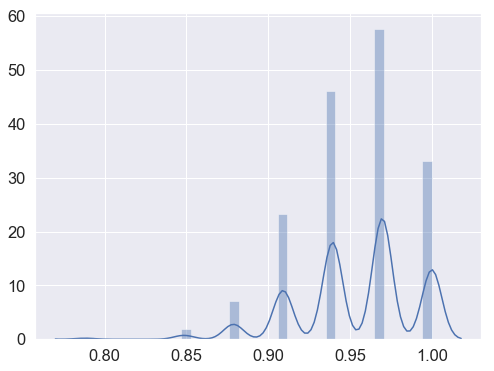

In [13]:
# Model accuracy
# take best estimator from gridsearch and shuffle split x times against train data to get an estimate of performance
clf = grid_search.best_estimator_
cv = model_selection.ShuffleSplit(n_splits=1000, test_size=.2)
cv_scores = model_selection.cross_val_score(clf, X, y, cv=cv)

# plot out the distribution of shufflesplit to get performance estimate
plt.figure(figsize=(8,6))
sns.set(font_scale=1.5)
sns.distributions.distplot(tuple(cv_scores))
print("average accuracy score:", cv_scores.mean())

In [35]:
# Create a dataframe showing all the mistakes made by the classifier
fail_analysis = actual.to_frame()
fail_analysis['predicted'] = predict

In [36]:
fail_analysis

,Radial,predicted
WAFER_ID,,
AZ2RG-10,0,0
AZ377-07,0,0
AZ2RU-19,1,1
AZ3FX-05,0,0
AZ34D-08,1,1
AZ2X5-05,1,0
AZ3G4-07,0,0
AZ3VK-13,0,0
AZ2RU-18,1,1


### Bernoulli Naive Bayes Model

In [14]:
# Bernoulli Naive Bayes Model
X,y = train.loc[:, train.columns != 'Radial'], train['Radial']
clf = naive_bayes.BernoulliNB()

# Gridsearch CV
parameter_grid = {'alpha' : [0.00000001, 0.0001, 0.001, 0.01, 0.1, 1]}

grid_search = model_selection.GridSearchCV(clf, parameter_grid)
grid_search.fit(X, y)
grid_search.best_estimator_

BernoulliNB(alpha=1e-08, binarize=0.0, class_prior=None, fit_prior=True)

average accuracy score: 0.9247575757575757


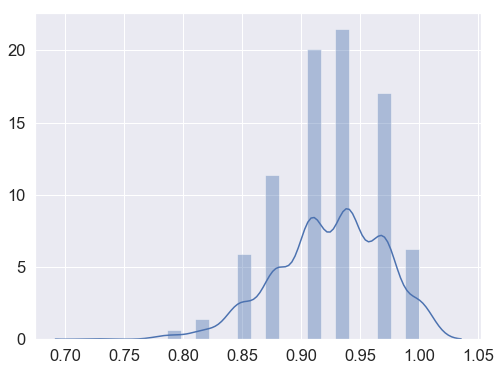

In [15]:
# Model accuracy
# take best estimator from gridsearch and shuffle split x times against train data to get an estimate of performance
clf = grid_search.best_estimator_
cv = model_selection.ShuffleSplit(n_splits=1000, test_size=.2)
cv_scores = model_selection.cross_val_score(clf, X, y, cv=cv)

# plot out the distribution of shufflesplit to get performance estimate
plt.figure(figsize=(8,6))
sns.set(font_scale=1.5)
sns.distributions.distplot(tuple(cv_scores))
print("average accuracy score:", cv_scores.mean())

### K Nearest Neighbors

In [16]:
# K Nearest Neighbors Model
X,y = train.loc[:, train.columns != 'Radial'], train['Radial']
clf = KNeighborsClassifier(n_jobs = -1)

# Gridsearch CV
parameter_grid = {'n_neighbors' : np.arange(5,20,1),
                 'weights' : ['uniform', 'distance'],}

grid_search = model_selection.GridSearchCV(clf, parameter_grid)
grid_search.fit(X, y)
grid_search.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=10, p=2,
           weights='distance')

average accuracy score: 0.6917575757575758


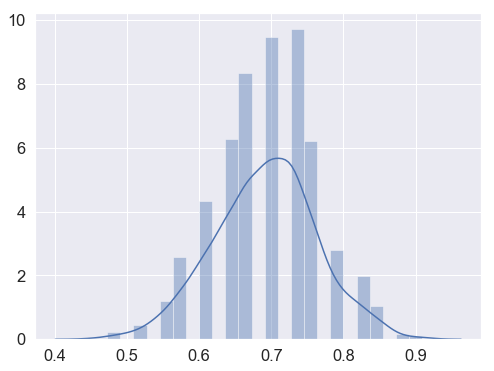

In [17]:
# Model accuracy
# take best estimator from gridsearch and shuffle split x times against train data to get an estimate of performance
clf = grid_search.best_estimator_
cv = model_selection.ShuffleSplit(n_splits=1000, test_size=.2)
cv_scores = model_selection.cross_val_score(clf, X, y, cv=cv)

# plot out the distribution of shufflesplit to get performance estimate
plt.figure(figsize=(8,6))
sns.set(font_scale=1.5)
sns.distributions.distplot(tuple(cv_scores))
print("average accuracy score:", cv_scores.mean())

In [41]:
# Save the model
joblib.dump(model, 'models/7nmRadial.sav')

['models/7nmRadial.sav']

In [ ]:
# Download the model
joblib_model= joblib.load('models/7nmRadial.sav')

In [54]:
model.predict_proba(train.loc[:, train.columns != 'Radial'])[:,1]

array([0.07784091, 0.03636364, 0.83173554, 0.10208333, 0.87264463,
       0.84431818, 0.95446281, 0.96809917, 0.97727273, 0.88636364,
       0.93969008, 0.87264463, 0.9453719 , 0.95900826, 0.92264463,
       0.94991736, 0.9453719 , 0.87636364, 0.97264463, 0.02727273,
       0.89545455, 0.02272727, 0.93173554, 0.10454545, 0.03636364,
       0.97977273, 0.01818182, 0.00454545, 0.        , 0.04      ,
       0.02272727, 0.00454545, 0.00909091, 0.11363636, 0.15454545,
       0.02727273, 0.        , 0.00454545, 0.05      , 0.04090909,
       0.06136364, 0.07264463, 0.77264463, 0.00909091, 0.00454545,
       0.07727273, 0.89082645, 0.03636364, 0.07272727, 0.03181818,
       0.05454545, 0.03181818, 0.09      , 0.04090909, 0.02727273,
       0.86355372, 0.82719008, 0.80446281, 0.77784091, 0.06818182,
       0.02272727, 0.06117424, 0.93325069, 0.27897727, 0.87832645,
       0.94423554, 0.34147727, 0.89105372, 0.91112948, 0.9353719 ,
       0.9453719 , 0.08333333, 0.16363636, 0.06287879, 0.75673

In [93]:
results = pd.DataFrame({'actual':train.Radial,'predicted':model.predict(train.loc[:, train.columns != 'Radial']),
                        'probability':model.predict_proba(train.loc[:, train.columns != 'Radial'])[:,1]})

In [95]:
results.to_csv('~/Downloads/Radial.csv')